In [179]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns
# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

from lightgbm import LGBMRegressor, early_stopping, log_evaluation

import eli5
from eli5.sklearn import PermutationImportance

from sklearn.preprocessing import MinMaxScaler
#standardscaler
from sklearn.preprocessing import StandardScaler
#robustscaler
from sklearn.preprocessing import RobustScaler

from sklearn.model_selection import StratifiedKFold

In [180]:
# 계약년월 formatting
def str_to_datetime(df: pd.DataFrame, col: str) -> pd.DataFrame:
    # 문자열에서 특수문자 제거('-')
    df[col] = df[col].astype(str).str.replace('-', '')
    # 문자열을 datetime으로 변환
    df[col] = pd.to_datetime(df[col], format='%Y%m')
    df[col] = df[col].dt.strftime('%Y-%m')
    return df
    

# target encoding 함수
def target_encoding(df_train: pd.DataFrame, df_test: pd.DataFrame, target_col: str, encode_col: str, 
                   alpha: float = 0.5, global_mean: float = None) -> tuple[pd.DataFrame, pd.DataFrame]:
    df_encoded_train = df_train.copy()
    df_encoded_test = df_test.copy()
    
    # 전체 평균 계산
    if global_mean is None:
        global_mean = df_train[target_col].mean()
    
    # 카테고리별 통계 계산
    category_stats = df_train.groupby(encode_col).agg({
        target_col: ['count', 'mean']
    }).reset_index()
    
    category_stats.columns = [encode_col, 'count', 'mean']
    
    # # 스무딩 적용
    # category_stats['smoothed_mean'] = (
    #     (category_stats['count'] * category_stats['mean'] + alpha * global_mean) / 
    #     (category_stats['count'] + alpha)
    # )
    
    # 인코딩 적용
    encoding_map = dict(zip(category_stats[encode_col], category_stats['mean']))
    
    # 학습 데이터에 적용
    df_encoded_train[f'{encode_col}_target'] = df_encoded_train[encode_col].map(encoding_map)
    
    # 테스트 데이터에 적용 (학습 데이터에 없는 카테고리는 전체 평균 사용)
    df_encoded_test[f'{encode_col}_target'] = df_encoded_test[encode_col].map(encoding_map)
    df_encoded_test[f'{encode_col}_target'].fillna(global_mean, inplace=True)
    
    return df_encoded_train, df_encoded_test
    
# 동 target encoding 함수
def dong_target_encoding(df_train: pd.DataFrame, df_test: pd.DataFrame, target_col: str) -> tuple[pd.DataFrame, pd.DataFrame]:
    df_encoded_train = df_train.copy()
    df_encoded_test = df_test.copy()

    #동 target encoding은 구 평균 집값에 대한 비율로 encoding
    df_gu_dong = df_encoded_train.groupby(['구', '동'])[target_col].mean().reset_index()
    df_gu = df_encoded_train.groupby('구')[target_col].mean().reset_index()
    df_gu.columns = ['구', '구_target']
    df_gu_dong = df_gu_dong.merge(df_gu, on='구', how='left')
    df_gu_dong['동_target'] = df_gu_dong[target_col] / df_gu_dong['구_target']
    

    encoding_map = dict(zip(df_gu_dong['동'], df_gu_dong['동_target']))

    df_encoded_train['동_target'] = df_encoded_train['동'].map(encoding_map)
    df_encoded_test['동_target'] = df_encoded_test['동'].map(encoding_map)

    # 테스트 데이터 결측치 채울 때 구 평균 사용
    df_encoded_test['동_target'].fillna(1, inplace=True)

    return df_encoded_train, df_encoded_test

# 아파트명 target encoding 함수
def apartment_target_encoding(df_train: pd.DataFrame, df_test: pd.DataFrame, target_col: str, alpha: float = 0.5) -> tuple[pd.DataFrame, pd.DataFrame]:
    df_encoded_train = df_train.copy()
    df_encoded_test = df_test.copy()

    # 아파트명 면적당가격
    df_cost_area = df_encoded_train.groupby(['아파트명', '구', '동'])[['전용면적', target_col]].agg(['count', 'mean']).reset_index()
    df_cost_area.columns = ['아파트명', '구', '동', '_', 'area_mean', 'count', 'target_mean']
    df_cost_area['면적당가격'] = df_cost_area['target_mean'] / df_cost_area['area_mean']

    # 구 면적당가격
    df_gu = df_encoded_train.groupby('구')[['전용면적', target_col]].mean().reset_index()
    df_gu['면적당가격'] = df_gu[target_col] / df_gu['전용면적']

    # 구 면적당가격 매핑
    gu_encoding_map = dict(zip(df_gu['구'], df_gu['면적당가격']))
    df_cost_area['구_면적당가격'] = df_cost_area['구'].map(gu_encoding_map)

    df_cost_area['면적당가격_smoothed'] = (
        (df_cost_area['면적당가격'] * df_cost_area['count'] + alpha * df_cost_area['구_면적당가격']) / 
        (df_cost_area['count'] + alpha)
    )
    

    # 동 면적당가격 
    df_dong = df_encoded_train.groupby('동')[['전용면적', target_col]].mean().reset_index()
    df_dong['면적당가격'] = df_dong[target_col] / df_dong['전용면적']

    # 동 면적당가격 매핑
    dong_encoding_map = dict(zip(df_dong['동'], df_dong['면적당가격']))
    df_cost_area['동_면적당가격'] = df_cost_area['동'].map(dong_encoding_map)

    # 테스트 데이터 결측치 채울 때 동 면적당가격 혹은 구 면적당가격으로 채우기
    df_encoded_test['동_면적당가격'] = df_encoded_test['동'].map(dong_encoding_map)
    df_encoded_test['구_면적당가격'] = df_encoded_test['구'].map(gu_encoding_map)

    # 아파트명 면적당가격 매핑
    df_encoding_map = dict(zip(df_cost_area['아파트명'], df_cost_area['면적당가격_smoothed']))
    df_encoded_train['아파트명_면적당가격'] = df_encoded_train['아파트명'].map(df_encoding_map)
    df_encoded_test['아파트명_면적당가격'] = df_encoded_test['아파트명'].map(df_encoding_map)
    df_encoded_test['아파트명_면적당가격'].fillna(df_encoded_test['동_면적당가격'], inplace=True)
    df_encoded_test['아파트명_면적당가격'].fillna(df_encoded_test['구_면적당가격'], inplace=True)
    df_encoded_test.drop(columns=['동_면적당가격', '구_면적당가격'], inplace=True)

    df_encoded_train.drop(columns=['아파트명', '구', '동', '시군구'], inplace=True)
    df_encoded_test.drop(columns=['아파트명', '구', '동', '시군구'], inplace=True)
    return df_encoded_train, df_encoded_test

# 라벨 인코딩 함수
def label_encoding(df_train: pd.DataFrame, df_test: pd.DataFrame, excp: list = []) -> tuple[pd.DataFrame, pd.DataFrame, dict]:
    dt_train = df_train.copy()
    dt_test = df_test.copy()
    categorical_features = dt_train.select_dtypes(include=[np.object]).columns
    categorical_features = categorical_features.drop(excp)
    # 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
    label_encoders = {}

    # Implement Label Encoding
    for col in tqdm( categorical_features ):
        # 모든 고유값 수집 (학습 + 테스트)

        # 모든 고유값 수집 (학습 + 테스트)
        all_unique_values = pd.concat([dt_train[col], dt_test[col]]).unique()
        
        # 레이블 인코더 생성 및 학습
        lbl = LabelEncoder()
        lbl.fit(all_unique_values.astype(str))  # 문자열로 변환
        
        # 변환
        dt_train[col] = lbl.transform(dt_train[col].astype(str))
        dt_test[col] = lbl.transform(dt_test[col].astype(str))
        
        label_encoders[col] = lbl
    return dt_train, dt_test, label_encoders

# 계약년월 2017년 전후 트렌드로 encoidng 하는 함수
from sklearn.linear_model import LinearRegression

def contract_encoding(df_train:pd.DataFrame, df_test:pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
  df_train_copy = df_train.copy()
  df_test_copy = df_test.copy()

  df_train_copy = str_to_datetime(df_train_copy, '계약년월')
  df_test_copy = str_to_datetime(df_test_copy, '계약년월')

  df_time_check = df_train_copy.groupby('계약년월')['target'].mean().reset_index()
  df_time_check.sort_values(by='계약년월', inplace=True)
  df_time_check['계약년월'] = pd.to_datetime(df_time_check['계약년월']).dt.strftime('%Y-%m')
  
  # 계약년월을 datetime으로 변환
  df_time_check['계약년월'] = pd.to_datetime(df_time_check['계약년월'])
  df_time_check = df_time_check.sort_values('계약년월').reset_index(drop=True)
  df_time_check['연도'] = df_time_check['계약년월'].dt.year

  # 2017년 기준으로 데이터 나누기
  df_before_2017 = df_time_check[df_time_check['연도'] < 2017].copy()
  df_after_2017 = df_time_check[df_time_check['연도'] >= 2017].copy()

  # 인코딩 맵 저장용 dict
  encoding_map = {}


  # 인코딩 값 생성
  def trend_encode(df, label):
      if len(df) < 2:
          return None
      n = len(df)
      y_start = df['target'].values[:3].mean()
      x = np.arange(n).reshape(-1, 1)
      y = df['target'].values.reshape(-1, 1)
      model = LinearRegression().fit(x, y)
      y_end = model.predict([[n - 1]])[0][0]
      y_trend = np.linspace(y_start, y_end, n)

      # 인코딩 맵에 저장
      for i, dt in enumerate(df['계약년월']):
          ym_str = dt.strftime('%Y-%m')
          encoding_map[ym_str] = y_trend[i]

      return model, y_start, n

  # 각 구간별 추세선 및 인코딩
  model_before, _, _ = trend_encode(df_before_2017, '2017년 이전 추세')
  model_after, y_start_after, n_after = trend_encode(df_after_2017, '2017년 이후 추세')

  # === 3개월 미래 예측 ===
  future_months = 3
  last_date = df_after_2017['계약년월'].max()

  for i in range(1, future_months + 1):
      future_date = last_date + pd.DateOffset(months=i)
      x_future = np.array([[n_after - 1 + i]])
      y_future = model_after.predict(x_future)[0][0]
      encoding_map[future_date.strftime('%Y-%m')] = y_future

  df_train_copy['계약년월'] = df_train_copy['계약년월'].map(encoding_map)
  df_test_copy['계약년월'] = df_test_copy['계약년월'].map(encoding_map)

  return df_train_copy, df_test_copy


In [181]:
#샘플 데이터 불러오기
whole = pd.read_csv("./../../Datas/updated_df2(knn).csv")


# 살릴 column들 정리
use_cols = np.array(['전용면적', '계약년월', '층','거래유형', 'k-전체동수',
'k-전체세대수', 'k-연면적', '주차대수', 'lat', 'long', 'target', 
'시군구', '아파트명', 'k-단지분류(아파트,주상복합등등)', 'k-세대타입(분양형태)',
'k-복도유형', 'k-난방방식', 'k-건설사(시공사)', 'k-시행사', 'k-홈페이지',
'is_test', '학군', '오마카세', '한강변', '신축여부', '건물연식'
])


df = whole[use_cols]

df['구'] = df['시군구'].str.split(' ').str[1]
df['동'] = df['시군구'].str.split(' ').str[1] + ' ' + df['시군구'].str.split(' ').str[2]
df_train = df[df['is_test'] == 0]
df_test = df[df['is_test'] == 1]
df_train.drop(columns=['is_test'], inplace=True)
df_test.drop(columns=['is_test', 'target'], inplace=True)



각 구별 최종 대표값:
       구  smoothed_target
0    강남구    195504.667390
1    강동구     93856.557096
2    강북구     54456.386708
3    강서구     69552.643644
4    관악구     63467.091339
5    광진구    100796.547568
6    구로구     52124.778352
7    금천구     55866.642313
8    노원구     59338.480091
9    도봉구     50072.866787
10  동대문구     67927.896180
11   동작구     92143.372292
12   마포구    109798.772123
13  서대문구     80887.737803
14   서초구    204343.363089
15   성동구    125083.052860
16   성북구     69651.193956
17   송파구    154299.419512
18   양천구     97646.094495
19  영등포구     88167.468788
20   용산구    178426.760228
21   은평구     64343.556737
22   종로구     74261.535575
23    중구     80304.032400
24   중랑구     52540.960494


(array([200600., 200800., 201000., 201200., 201400., 201600., 201800.,
        202000., 202200., 202400.]),
 [Text(200600.0, 0, '200600'),
  Text(200800.0, 0, '200800'),
  Text(201000.0, 0, '201000'),
  Text(201200.0, 0, '201200'),
  Text(201400.0, 0, '201400'),
  Text(201600.0, 0, '201600'),
  Text(201800.0, 0, '201800'),
  Text(202000.0, 0, '202000'),
  Text(202200.0, 0, '202200'),
  Text(202400.0, 0, '202400')])

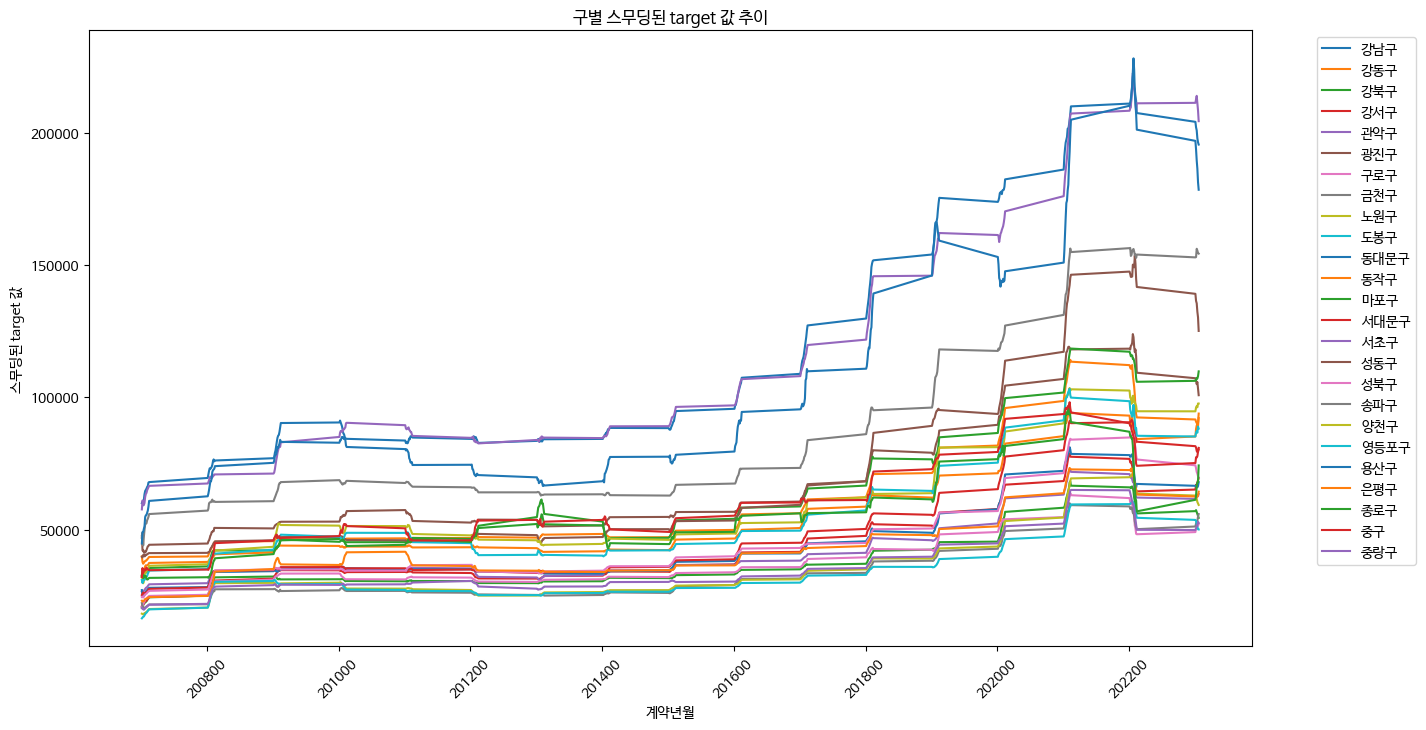

In [182]:
# 구별, 계약년월별 target 값의 이동평균 계산
smoothed_values = df_train.groupby(['구', '계약년월'])['target'].mean().reset_index()

# 각 구별로 12개월 이동평균 계산
smoothed_values['smoothed_target'] = smoothed_values.groupby('구')['target'].transform(
    lambda x: x.rolling(window=12, min_periods=1).mean()
)


# 각 구별 최종 대표값 계산 (최근 12개월 평균)
final_representative = smoothed_values.groupby('구')['smoothed_target'].last().reset_index()
print("\n각 구별 최종 대표값:")
print(final_representative)

# 시각화
plt.figure(figsize=(15, 8))
for district in final_representative['구'].unique():
    district_data = smoothed_values[smoothed_values['구'] == district]
    plt.plot(district_data['계약년월'], district_data['smoothed_target'], label=district)

plt.title('구별 스무딩된 target 값 추이')
plt.xlabel('계약년월')
plt.ylabel('스무딩된 target 값')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)



In [183]:
# 집값 순서대로 구 정렬
final_representative = final_representative.sort_values(by='smoothed_target', ascending=False)
display(final_representative)

# 집값 서열 대로 높은 그룹, 중간 그룹, 낮은 그룹으로 나누기누기
target_order_list = final_representative['구'].values
display(target_order_list)
high_group = target_order_list[:3]
mid_group = target_order_list[3:5]
low_group = target_order_list[5:]

,구,smoothed_target
14,서초구,204343.363089
0,강남구,195504.667390
20,용산구,178426.760228
17,송파구,154299.419512
15,성동구,125083.052860
12,마포구,109798.772123
5,광진구,100796.547568
18,양천구,97646.094495
1,강동구,93856.557096
11,동작구,92143.372292


array(['서초구', '강남구', '용산구', '송파구', '성동구', '마포구', '광진구', '양천구', '강동구',
       '동작구', '영등포구', '서대문구', '중구', '종로구', '성북구', '강서구', '동대문구', '은평구',
       '관악구', '노원구', '금천구', '강북구', '중랑구', '구로구', '도봉구'], dtype=object)

In [184]:
# # 각 그룹 간 데이터 개수 파악
# df_high = df_train[df_train['구'].isin(high_group)]
# df_mid = df_train[df_train['구'].isin(mid_group)]
# df_low = df_train[df_train['구'].isin(low_group)]
# display(len(df_high))
# display(len(df_mid))
# display(len(df_low))


In [196]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupKFold
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
import numpy as np
import pandas as pd

def model_traning_by_price(df_train:pd.DataFrame, df_test:pd.DataFrame) -> tuple:
    df_train = df_train.copy()
    df_test = df_test.copy()

    numeric_features = df_train.select_dtypes(include=[np.number]).columns
    categorical_features = df_train.select_dtypes(include=[np.object]).columns

    df_train[categorical_features] = df_train[categorical_features].fillna('NULL')
    df_test[categorical_features] = df_test[categorical_features].fillna('NULL')

    #레이블 인코딩
    df_train, df_test, label_encoders = label_encoding(df_train, df_test,['아파트명', '구', '동'])

    # 그룹별 데이터 분리
    df_high = df_train[df_train['구'].isin(high_group)].copy()
    df_mid = df_train[df_train['구'].isin(mid_group)].copy()
    df_low = df_train[df_train['구'].isin(low_group)].copy()

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # GroupKFold 설정
    # n_splits = 5
    # gkf = GroupKFold(n_splits=n_splits)

    # 공통 함수 정의
    def train_group_model(df, group_name):
        # df['target_bin'] = pd.qcut(df['target'], q=6, labels=False)

        # X = df.drop(columns=['target'])
        # y = df['target']
        # groups = df['구']  # 동일 구는 같은 fold에 묶이도록
        train_rmse_scores = []
        rmse_scores = []
        models = []
        df_len = len(df)

        print(f'\n🚀 Training group: {group_name}')

        for fold, (train_index, valid_index) in enumerate(skf.split(df, df['동'])):
            print(f'Fold {fold+1} : {len(train_index)} / {len(valid_index)}')
            train_df = df.iloc[train_index]
            valid_df = df.iloc[valid_index]
            # model = LGBMRegressor(n_estimators=1000, learning_rate=0.05)
            # model.fit(
            #     X_train, y_train,
            #     eval_set=[(X_val, y_val)],
            #     early_stopping_rounds=50,
            #     verbose=100
            # )
            
            # 구 target encoding
            train_df, valid_df = target_encoding(train_df, valid_df, 'target', '구')
            # 동 target encoding
            train_df, valid_df = dong_target_encoding(train_df, valid_df, 'target')

            # 아파트명 target encoding
            train_df, valid_df = apartment_target_encoding(train_df, valid_df, 'target')

            # 계약년월 target encoding
            train_df, valid_df = contract_encoding(train_df, valid_df)

            #결측치 처리
            train_df[numeric_features] = train_df[numeric_features].interpolate(method='linear', axis=0).fillna(method='bfill').fillna(method='ffill')
            valid_df[numeric_features] = valid_df[numeric_features].interpolate(method='linear', axis=0).fillna(method='bfill').fillna(method='ffill')

            
            # 모델 학습
            y_train = train_df['target']
            X_train = train_df.drop(['target'], axis=1)
            y_valid = valid_df['target']
            X_valid = valid_df.drop(['target'], axis=1)

            features = X_train.columns

            model = RandomForestRegressor(n_estimators=5, criterion='squared_error', random_state=1, n_jobs=-1)
            model.fit(X_train, y_train)

            # train과 valid 예측
            train_pred = model.predict(X_train)
            valid_pred = model.predict(X_valid)
            
            # RMSE 계산
            train_rmse = np.sqrt(metrics.mean_squared_error(y_train, train_pred))
            valid_rmse = np.sqrt(metrics.mean_squared_error(y_valid, valid_pred))
            
            # 점수 저장
            train_rmse_scores.append(train_rmse)
            rmse_scores.append(valid_rmse)
            models.append(model)

            print(f'Fold {fold+1} : train RMSE : {train_rmse:.4f}, valid RMSE : {valid_rmse:.4f}\n')


        print(f'{group_name} Average Train RMSE: {np.mean(train_rmse_scores):.4f} ± {np.std(train_rmse_scores):.4f}')
        print(f'{group_name} Average Valid RMSE: {np.mean(rmse_scores):.4f} ± {np.std(rmse_scores):.4f}')
        total_train_rmse = np.mean(train_rmse_scores) * df_len
        total_valid_rmse = np.mean(rmse_scores) * df_len

            
        return models, features, total_train_rmse, total_valid_rmse, df_len

    # 학습 실행
    high_models, features, total_train_rmse_high, total_valid_rmse_high, high_len = train_group_model(df_high, '고가')
    mid_models, features, total_train_rmse_mid, total_valid_rmse_mid, mid_len = train_group_model(df_mid, '중가')
    low_models, features, total_train_rmse_low, total_valid_rmse_low, low_len = train_group_model(df_low, '저가')

    total_train_rmse = (total_train_rmse_high + total_train_rmse_mid + total_train_rmse_low) / (high_len + mid_len + low_len)
    total_valid_rmse = (total_valid_rmse_high + total_valid_rmse_mid + total_valid_rmse_low) / (high_len + mid_len + low_len)

    print(f'Total Train RMSE: {total_train_rmse:.4f}, Total Valid RMSE: {total_valid_rmse:.4f}')
    return high_models, mid_models, low_models, features


In [197]:
high_models,mid_models,low_models,features = model_traning_by_price(df_train, df_test)

100%|██████████| 9/9 [00:04<00:00,  1.87it/s]



🚀 Training group: 고가
Fold 1 : 114208 / 28552
Fold 1 : train RMSE : 6473.4488, valid RMSE : 13727.7183

Fold 2 : 114208 / 28552
Fold 2 : train RMSE : 6111.0300, valid RMSE : 13889.4603

Fold 3 : 114208 / 28552
Fold 3 : train RMSE : 6102.8080, valid RMSE : 13512.9652

Fold 4 : 114208 / 28552
Fold 4 : train RMSE : 6202.4079, valid RMSE : 13412.4294

Fold 5 : 114208 / 28552
Fold 5 : train RMSE : 6282.4876, valid RMSE : 14469.2702

고가 Average Train RMSE: 6234.4365 ± 136.3942
고가 Average Valid RMSE: 13802.3687 ± 372.4842

🚀 Training group: 중가
Fold 1 : 90514 / 22629
Fold 1 : train RMSE : 3223.4675, valid RMSE : 6853.4875

Fold 2 : 90514 / 22629
Fold 2 : train RMSE : 3369.5374, valid RMSE : 7314.6291

Fold 3 : 90514 / 22629
Fold 3 : train RMSE : 3444.0868, valid RMSE : 7459.0523

Fold 4 : 90515 / 22628
Fold 4 : train RMSE : 3281.3260, valid RMSE : 7013.1430

Fold 5 : 90515 / 22628
Fold 5 : train RMSE : 3208.6476, valid RMSE : 8079.8563

중가 Average Train RMSE: 3305.4131 ± 89.4440
중가 Average Val

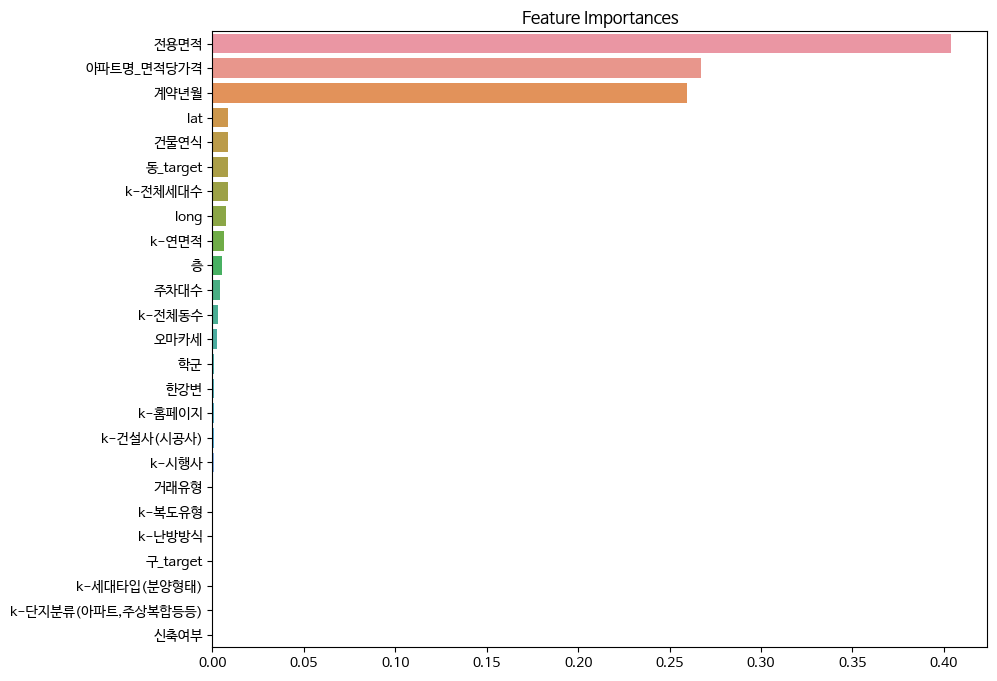

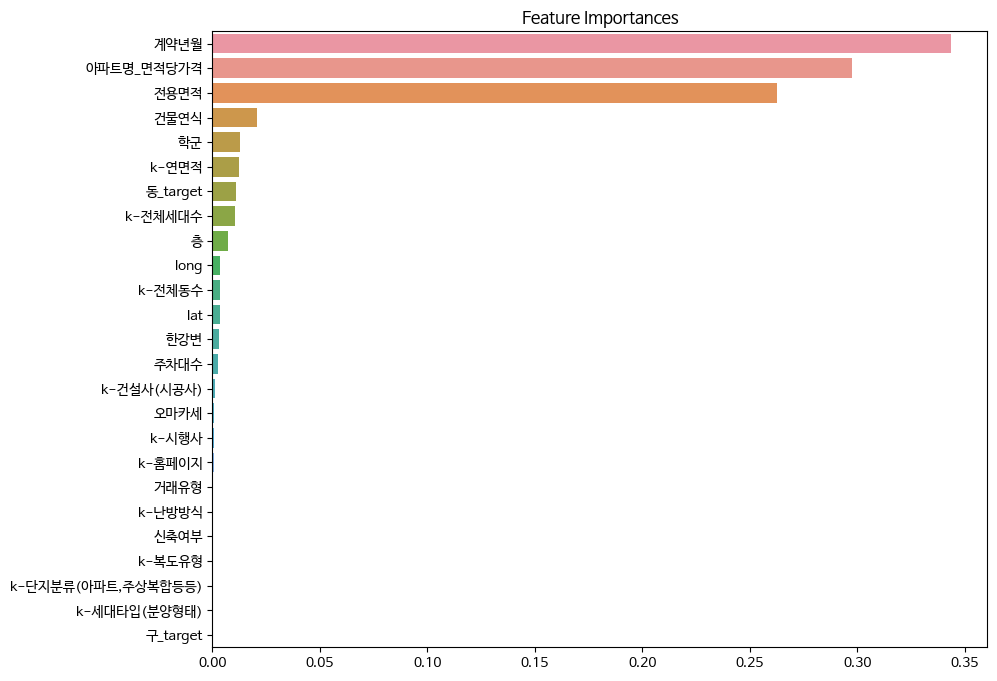

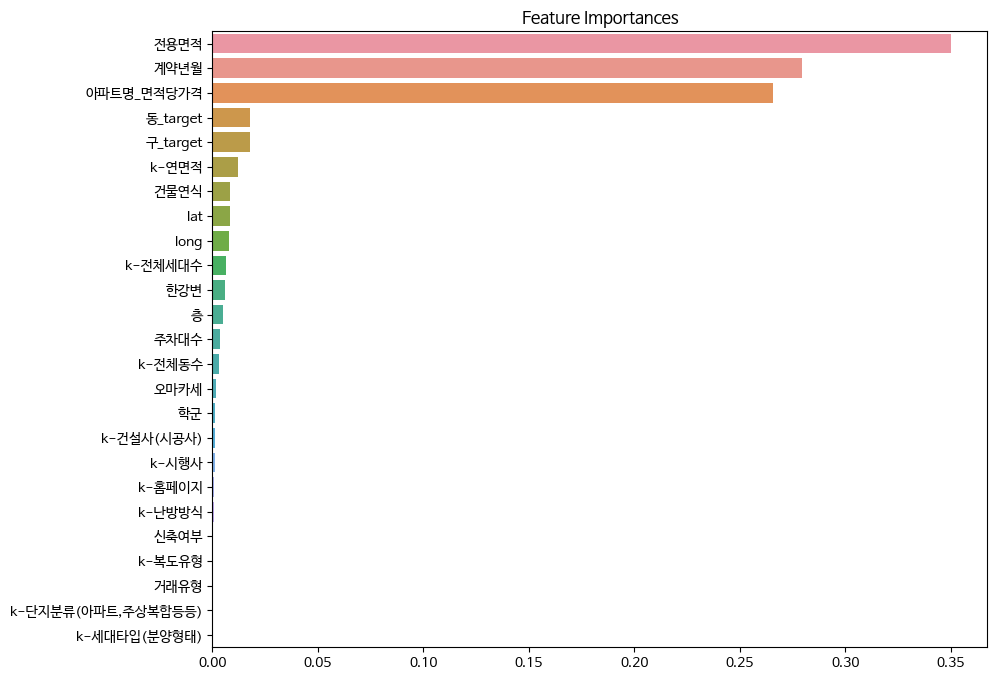

In [194]:
#각 모델의 feature_importances plot 
model_high = high_models[0]
model_mid = mid_models[0]
model_low = low_models[0]

importances = pd.Series(model_high.feature_importances_, index=features)
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

importances = pd.Series(model_mid.feature_importances_, index=features)
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

importances = pd.Series(model_low.feature_importances_, index=features)
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [170]:
def inference(models, df_train, df_test, group) -> tuple[np.ndarray, np.ndarray]:
    df_group_train = df_train[df_train['구'].isin(group)]
    df_group_test = df_test[df_test['구'].isin(group)]
    test_idx = df_group_test.index
    # 구 target encoding
    train_df, test_df = target_encoding(df_group_train, df_group_test, 'target', '구')
    # 동 target encoding
    train_df, test_df = dong_target_encoding(train_df, test_df, 'target')

    # 아파트명 target encoding
    train_df, test_df = apartment_target_encoding(train_df, test_df, 'target')

    # 계약년월 target encoding
    train_df, test_df = contract_encoding(train_df, test_df)

    numeric_features = test_df.select_dtypes(include=[np.number]).columns
    #결측치 처리
    test_df[numeric_features] = test_df[numeric_features].interpolate(method='linear', axis=0).fillna(method='bfill').fillna(method='ffill')

    preds = []
    for model in models:
        pred = model.predict(test_df)
        preds.append(pred)
    pred = np.mean(preds, axis=0)

    return pred, test_idx

In [171]:
categorical_features = df_train.select_dtypes(include=[np.object]).columns

df_train[categorical_features] = df_train[categorical_features].fillna('NULL')
df_test[categorical_features] = df_test[categorical_features].fillna('NULL')

#레이블 인코딩
df_train, df_test, label_encoders = label_encoding(df_train, df_test, excp=['아파트명', '구', '동'])

pred_high, high_idx = inference(high_models, df_train, df_test, high_group)
pred_mid, mid_idx = inference(mid_models, df_train, df_test, mid_group)
pred_low, low_idx = inference(low_models, df_train, df_test, low_group)

#예측 결과 합치기
pred_high = pd.Series(pred_high, index=high_idx)
pred_mid = pd.Series(pred_mid, index=mid_idx)
pred_low = pd.Series(pred_low, index=low_idx)

pred = pd.concat([pred_high, pred_mid, pred_low], axis=0).sort_index()

# 값 정수화, pred 컬럼명 변경
pred = pred.astype(int)
pred = pred.rename('target')
pred.to_csv('./../../Datas/pred_high_mid_low.csv', index=False)




100%|██████████| 9/9 [00:04<00:00,  1.84it/s]


In [152]:
pred.to_csv('./../../Datas/pred_high_mid_low.csv', index=False)

In [150]:
dd = pd.read_csv('./../../Datas/pred_high_mid_low.csv')
dd.head()

,0
0,217004
1,313473
2,330440
3,299274
4,210740
